In [107]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

import cv2

from PIL import Image
from PIL import ImageChops

from skimage import io
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

from sklearn import linear_model

from matplotlib import cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cpu


In [108]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [109]:
alexnet = models.alexnet(pretrained=True)

In [110]:
transformForModel = transforms.Compose([          
  transforms.Resize(256),                    
  transforms.CenterCrop(224),                
  transforms.ToTensor(),                    
  transforms.Normalize(                     
  mean=[0.485, 0.456, 0.406],               
  std=[0.229, 0.224, 0.225]                
)])

In [111]:
img = Image.open('drive/My Drive/dog.jpg')
img_t = transformForModel(img)
batch_t = torch.unsqueeze(img_t, 0)

In [112]:
alexnet.eval()
out = alexnet(batch_t)

In [113]:
with open('drive/My Drive/imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]

_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

208, Labrador_retriever 41.58515930175781


In [114]:
_, indices = torch.sort(out, descending=True)
[(classes[idx], percentage[idx].item()) for idx in indices[0][:3]]

[('208, Labrador_retriever', 41.58515930175781),
 ('207, golden_retriever', 16.591659545898438),
 ('176, Saluki', 16.286876678466797)]

In [115]:
top_three = indices[0][:3]
top_three = top_three.numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  


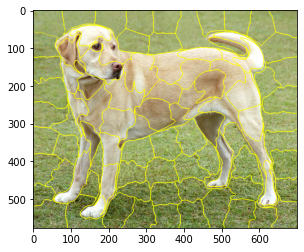

In [116]:
src = io.imread('drive/My Drive/dog.jpg')
sk_slic = slic(src,n_segments = 100, sigma = 5)

plt.imshow(mark_boundaries(src, sk_slic))

In [117]:
#Getting unique values
unique_super_Pixel = np.unique(sk_slic)
unique_super_Pixel

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [118]:
def generate_new_sample(max_remove):
    #Getting max value
    max_super_pixel = unique_super_Pixel.max() + 1

    #Binary vector
    binary_vector = np.ones(max_super_pixel).astype('uint8')

    #Getting random value for deletion
    random_index = round(np.random.uniform(max_remove + 1, max_super_pixel - max_remove - 1))
    to_remove = round(np.random.uniform(0, max_remove)) + 1 #Remove up to three super pixels
    left_right = -1 if np.random.uniform(0, 1) < 0.5 else 1  #Remove from the left or right

    super_pixel_to_delete = []

    for i in range(0, to_remove):
        super_pixel_to_delete.append(unique_super_Pixel[random_index-1])
        random_index += left_right 

    #Creating new sample based on the random value
    new_sample = binary_vector.copy()
    new_sample_img = src.copy()
    for val in super_pixel_to_delete:
      new_sample[val] = 0
      new_sample_img[sk_slic == val] = 0

    #Calculating the difference
    src_norm = src / src.max()
    img_norm = new_sample_img / new_sample_img.max()
    diff = np.linalg.norm(src_norm - img_norm)

    #return new binary vector, the new image, and the difference from the original image
    return new_sample, new_sample_img, diff

In [119]:
#Generating local dataset
dataset_size = 400

binary_samples = []
image_samples = []
diff_array = []

for i in range(dataset_size):
    res = generate_new_sample(2)
    binary_samples.append(res[0])
    image_samples.append(res[1])
    diff_array.append(res[2])

In [120]:
top_three

array([208, 207, 176])

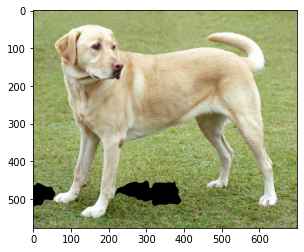

In [121]:
plt.imshow(image_samples[10])

In [122]:
def predictions_for_local_dataset():
    alexnet.eval()

    #Getting classes
    with open('drive/My Drive/imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]

    predictions = []

    for image in image_samples:
        #Conver it to PIL image
        pil_image = Image.fromarray(image.astype('uint8'), 'RGB')

        transformed_image = transformForModel(pil_image)
        transformed_batch = torch.unsqueeze(transformed_image, 0)

        #Get predication
        out = alexnet(transformed_batch)
        _, index = torch.max(out, 1)
        
        predictions.append((top_three == index.numpy()[0]).astype('uint8'))

    return predictions

In [123]:
predictions = predictions_for_local_dataset()

In [124]:
binary_samples[38]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=uint8)

In [125]:
diff_array[38]

117.88917596003125

In [126]:
predictions[38]

array([0, 0, 0], dtype=uint8)

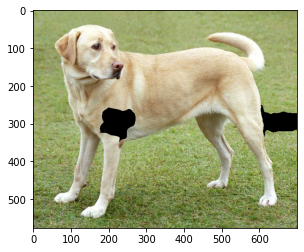

In [127]:
plt.imshow(image_samples[38])

In [128]:
#Conver it to PIL image
pil_image = Image.fromarray(image_samples[16].astype('uint8'), 'RGB')

img_t1 = transformForModel(pil_image)
batch_t1 = torch.unsqueeze(img_t1, 0)

alexnet.eval()
out = alexnet(batch_t1)

with open('drive/My Drive/imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]

_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

208, Labrador_retriever 38.10300064086914


In [129]:
predictions[:10]

[array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 0, 1], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 0, 1], dtype=uint8),
 array([1, 0, 0], dtype=uint8)]

I Could have used Lasso, but it didn't converge for some reason. Leon said it was ok. I used some threshold to zero out the low Coeficientes Becuase Ridge uses L2 norm.

In [130]:
ridge = linear_model.Ridge(alpha=1, fit_intercept=True)
ridge.fit(binary_samples, predictions, sample_weight=diff_array)

Ridge(alpha=1)

In [131]:
prediction_score = ridge.score(binary_samples, predictions, sample_weight=diff_array)
local_pred = ridge.predict(binary_samples)

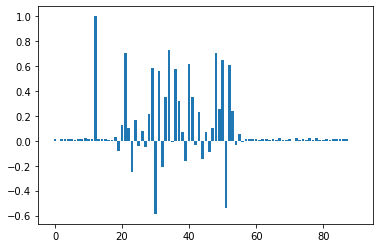

In [132]:
importance = ridge.coef_
importance = importance.sum(axis=0)
importance = importance / importance.max()

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [133]:
#Use some threshold
not_important_features = unique_super_Pixel[abs(importance) < 0.2]

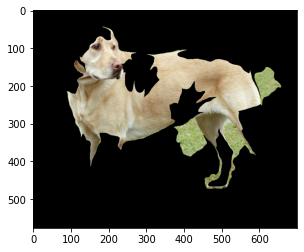

In [134]:
temp = src.copy()
for feature in not_important_features:
    temp[sk_slic == feature] = 0

plt.imshow(temp)

In [135]:
#Second picure

In [136]:
img = Image.open('drive/My Drive/radio.jpg')
img_t = transformForModel(img)
batch_t = torch.unsqueeze(img_t, 0)

alexnet.eval()
out = alexnet(batch_t)

_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

754, radio 43.72721481323242


In [137]:
_, indices = torch.sort(out, descending=True)
[(classes[idx], percentage[idx].item()) for idx in indices[0][:3]]

[('754, radio', 43.72721481323242),
 ('848, tape_player', 31.14469337463379),
 ('482, cassette_player', 17.034793853759766)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


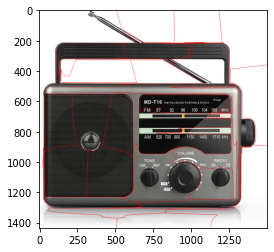

In [138]:
top_three = indices[0][:3]
top_three = top_three.numpy()

src = io.imread('drive/My Drive/radio.jpg')
sk_slic = slic(src,n_segments = 40, sigma = 5)

plt.imshow(mark_boundaries(src, sk_slic, color=(255, 0, 0)))

In [139]:
#Getting unique values
unique_super_Pixel = np.unique(sk_slic)
unique_super_Pixel

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [140]:
#Generating local dataset
dataset_size = 100

binary_samples = []
image_samples = []
diff_array = []

for i in range(dataset_size):
    res = generate_new_sample(2)
    binary_samples.append(res[0])
    image_samples.append(res[1])
    diff_array.append(res[2])

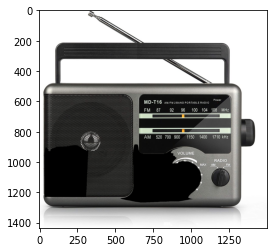

In [141]:
plt.imshow(image_samples[13])

In [142]:
predictions = predictions_for_local_dataset()

#Conver it to PIL image
pil_image = Image.fromarray(image_samples[16].astype('uint8'), 'RGB')

img_t1 = transformForModel(pil_image)
batch_t1 = torch.unsqueeze(img_t1, 0)

alexnet.eval()
out = alexnet(batch_t1)

_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

predictions[:10]

754, radio 39.935237884521484


[array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 1, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 1, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 1, 0], dtype=uint8)]

     predictions[14] = [0 1 0]


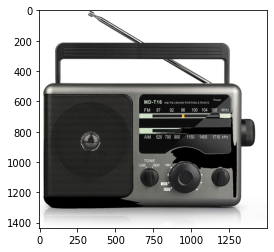

In [143]:
plt.imshow(image_samples[14])
print(f'     predictions[14] = {predictions[14]}')

In [144]:
ridge = linear_model.Ridge(alpha=1, fit_intercept=True)
ridge.fit(binary_samples, predictions, sample_weight=diff_array)

prediction_score = ridge.score(binary_samples, predictions, sample_weight=diff_array)
local_pred = ridge.predict(binary_samples)

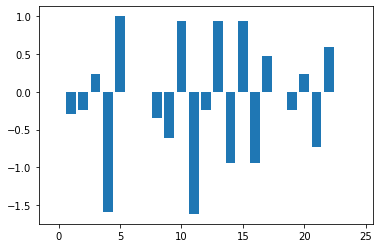

In [145]:
importance = ridge.coef_
importance = importance.sum(axis=0)
importance = importance / importance.max()

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [146]:
#Use some threshold
not_important_features = unique_super_Pixel[importance < 0.4]

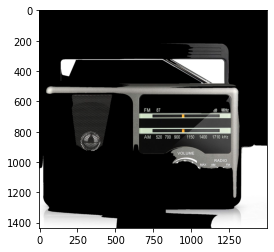

In [147]:
temp = src.copy()
for feature in not_important_features:
    temp[sk_slic == feature] = 0

plt.imshow(temp)

In [148]:
#Third picture

In [149]:
img = Image.open('drive/My Drive/laptopCat.jpg')
img_t = transformForModel(img)
batch_t = torch.unsqueeze(img_t, 0)

alexnet.eval()
out = alexnet(batch_t)

_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

333, hamster 38.5870475769043


In [150]:
_, indices = torch.sort(out, descending=True)
[(classes[idx], percentage[idx].item()) for idx in indices[0][:3]]

[('333, hamster', 38.5870475769043),
 ('341, hog', 7.539167881011963),
 ('620, laptop', 6.195697784423828)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


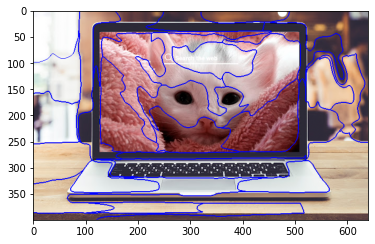

In [151]:
top_three = indices[0][:3]
top_three = top_three.numpy()

src = io.imread('drive/My Drive/laptopCat.jpg')
sk_slic = slic(src,n_segments = 40, sigma = 5)

plt.imshow(mark_boundaries(src, sk_slic, color=(0, 0, 255)))

In [152]:
#Getting unique values
unique_super_Pixel = np.unique(sk_slic)

#Generating local dataset
dataset_size = 100

binary_samples = []
image_samples = []
diff_array = []

for i in range(dataset_size):
    res = generate_new_sample(2)
    binary_samples.append(res[0])
    image_samples.append(res[1])
    diff_array.append(res[2])

predictions = predictions_for_local_dataset()

#Conver it to PIL image
pil_image = Image.fromarray(image_samples[16].astype('uint8'), 'RGB')

img_t1 = transformForModel(pil_image)
batch_t1 = torch.unsqueeze(img_t1, 0)

alexnet.eval()
out = alexnet(batch_t1)

_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

predictions[:10]

341, hog 29.636720657348633


[array([0, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([0, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8)]

     predictions[14] = [1 0 0]


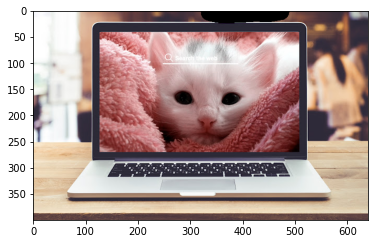

In [153]:
plt.imshow(image_samples[1])
print(f'     predictions[14] = {predictions[1]}')

In [154]:
ridge = linear_model.Ridge(alpha=1, fit_intercept=True)
ridge.fit(binary_samples, predictions, sample_weight=diff_array)

prediction_score = ridge.score(binary_samples, predictions, sample_weight=diff_array)
local_pred = ridge.predict(binary_samples)

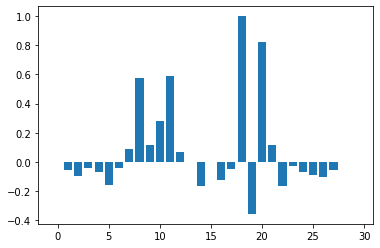

In [155]:
importance = ridge.coef_
importance = importance.sum(axis=0)
importance = importance / importance.max()

# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

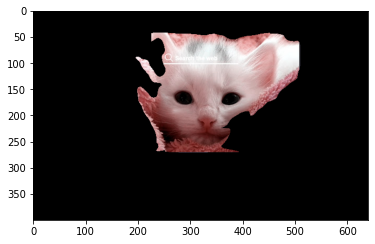

In [156]:
#Use some threshold
not_important_features = unique_super_Pixel[importance < 0.2]

temp = src.copy()
for feature in not_important_features:
    temp[sk_slic == feature] = 0

plt.imshow(temp)